In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-accidents/US_Accidents_June20.csv


In [2]:
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import glob
import re
import io
from scipy.stats import boxcox

**1. Overview and Basic Analysis**

**1.1 Overview the dataset**

In [3]:
df = pd.read_csv('../input/us-accidents/US_Accidents_June20.csv')
print("The shape of data is:",(df.shape))
display(df.head(5))

The shape of data is: (3513617, 49)


,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


Details about features(49) in the dataset:


Traffic Attributes (12):
* ID: This is a unique identifier of the accident record.
* Source: Indicates source of the accident report (i.e. the API which reported the accident.).
* TMC: A traffic accident may have a Traffic Message Channel (TMC) code which provides more detailed description of the event.
* Severity: Shows the severity of the accident, a number between 1 and 4, where 1 indicates the least impact on traffic (i.e., short delay as a result of the accident) and 4 indicates a significant impact on traffic (i.e., long delay).
* Start_Time: Shows start time of the accident in local time zone.
* End_Time: Shows end time of the accident in local time zone.
* Start_Lat: Shows latitude in GPS coordinate of the start point.
* Start_Lng: Shows longitude in GPS coordinate of the start point.
* End_Lat: Shows latitude in GPS coordinate of the end point.
* End_Lng: Shows longitude in GPS coordinate of the end point.
* Distance(mi): The length of the road extent affected by the accident.
* Description: Shows natural language description of the accident.


Address Attributes (9):
* Number: Shows the street number in address field.
* Street: Shows the street name in address field.
* Side: Shows the relative side of the street (Right/Left) in address field.
* City: Shows the city in address field.
* County: Shows the county in address field.
* State: Shows the state in address field.
* Zipcode: Shows the zipcode in address field.
* Country: Shows the country in address field.
* Timezone: Shows timezone based on the location of the accident (eastern, central, etc.).


Weather Attributes (11):
* Airport_Code: Denotes an airport-based weather station which is the closest one to location of the accident.
* Weather_Timestamp: Shows the time-stamp of weather observation record (in local time).
* Temperature(F): Shows the temperature (in Fahrenheit).
* Wind_Chill(F): Shows the wind chill (in Fahrenheit).
* Humidity(%): Shows the humidity (in percentage).
* Pressure(in): Shows the air pressure (in inches).
* Visibility(mi): Shows visibility (in miles).
* Wind_Direction: Shows wind direction.
* Wind_Speed(mph): Shows wind speed (in miles per hour).
* Precipitation(in): Shows precipitation amount in inches, if there is any.
* Weather_Condition: Shows the weather condition (rain, snow, thunderstorm, fog, etc.).


POI Attributes (13):
* Amenity: A Point-Of-Interest (POI) annotation which indicates presence of amenity in a nearby location.
* Bump: A POI annotation which indicates presence of speed bump or hump in a nearby location.
* Crossing: A POI annotation which indicates presence of crossing in a nearby location.
* Give_Way: A POI annotation which indicates presence of give_way sign in a nearby location.
* Junction: A POI annotation which indicates presence of junction in a nearby location.
* No_Exit: A POI annotation which indicates presence of no_exit sign in a nearby location.
* Railway: A POI annotation which indicates presence of railway in a nearby location.
* Roundabout: A POI annotation which indicates presence of roundabout in a nearby location.
* Station: A POI annotation which indicates presence of station (bus, train, etc.) in a nearby location.
* Stop: A POI annotation which indicates presence of stop sign in a nearby location.
* Traffic_Calming: A POI annotation which indicates presence of traffic_calming means in a nearby location.
* Traffic_Signal: A POI annotation which indicates presence of traffic_signal in a nearby location.
* Turning_Loop: A POI annotation which indicates presence of turning_loop in a nearby location.


Period-of-Day (4):
* Sunrise_Sunset: Shows the period of day (i.e. day or night) based on sunrise/sunset.
* Civil_Twilight: Shows the period of day (i.e. day or night) based on civil twilight.
* Nautical_Twilight: Shows the period of day (i.e. day or night) based on nautical twilight.
* Astronomical_Twilight: Shows the period of day (i.e. day or night) based on astronomical twilight.

Lets separate the datasets based on data type so that we can make good analysis

In [4]:
dtype_df = df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,ID,object
1,Source,object
2,TMC,float64
3,Severity,int64
4,Start_Time,object
5,End_Time,object
6,Start_Lat,float64
7,Start_Lng,float64
8,End_Lat,float64
9,End_Lng,float64


In [5]:
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,bool,13
1,int64,1
2,float64,14
3,object,21


**1.2 Reporting Sources**

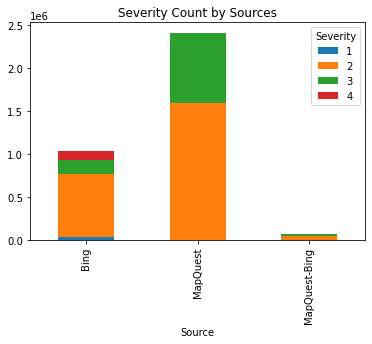

In [6]:
df_source = df.groupby(['Severity','Source']).size().reset_index().pivot(\
    columns='Severity', index='Source', values=0)
df_source.plot(kind='bar', stacked=True, title='Severity Count by Sources')

In [7]:
df.groupby('Severity').size()

Severity
1      29174
2    2373210
3     998913
4     112320
dtype: int64

The results indicate that there are two main sources, Bing and MapQuest. Meanwhile, we can see that most accidents are moderately severe in degree 2 and 3. 

**1.3 States**

****

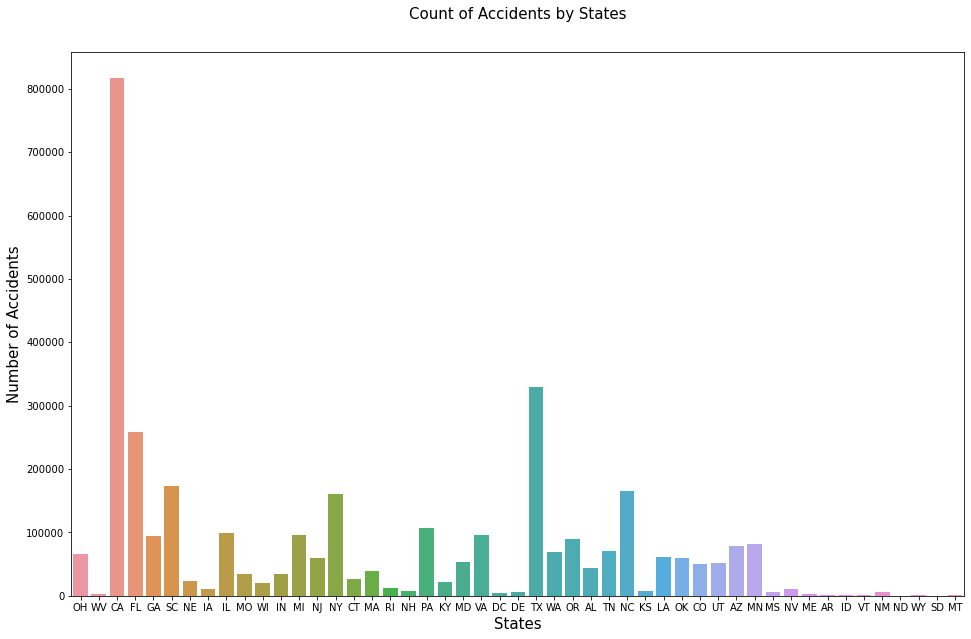

In [8]:
states = df.State.unique()

count_by_state=[]
for i in df.State.unique():
    count_by_state.append(df[df['State']==i].count()['ID'])

fig,ax = plt.subplots(figsize=(16,10))
sns.barplot(states,count_by_state)
plt.title("Count of Accidents by States", size=15, y=1.05)
plt.xlabel('States',fontsize=15)
plt.ylabel('Number of Accidents',fontsize=15)
plt.show()


California, Texas and Florida are the TOP 3 traffic accident prone states.

**1.4 Weather**

What weather conditions are most common when accidents occur?

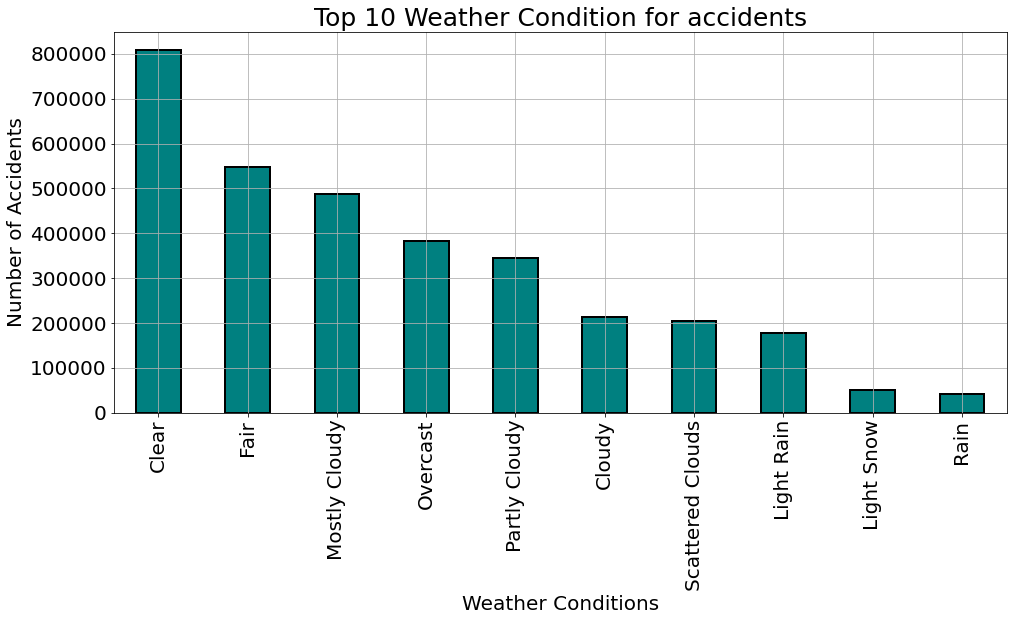

In [9]:
fig, ax=plt.subplots(figsize=(16,7))
df['Weather_Condition'].value_counts().sort_values(ascending=False).head(10).plot.bar(width=0.5,color='Teal',edgecolor='k',align='center',linewidth=2)
plt.xlabel('Weather Conditions',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('Top 10 Weather Condition for accidents',fontsize=25)
plt.grid()
plt.ioff()

**1.5 Durations**

Top 15 longest accidents correspond to 78.8% of the data


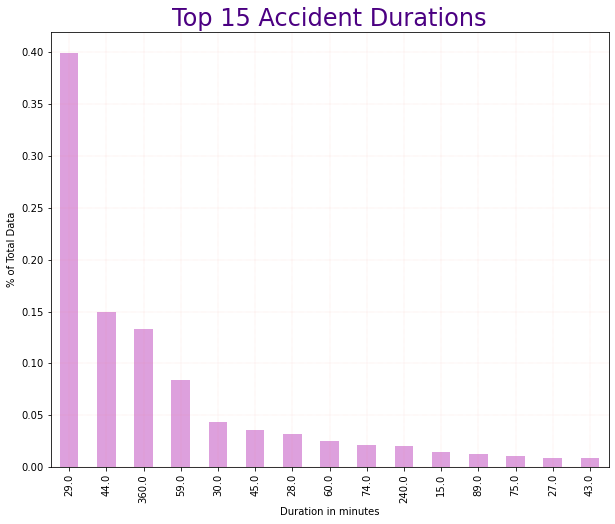

In [10]:
start = pd.to_datetime(df.Start_Time, format='%Y-%m-%d %H:%M:%S')
end = pd.to_datetime(df.End_Time, format='%Y-%m-%d %H:%M:%S')
laps=end-start
top_15 = laps.astype('timedelta64[m]').value_counts().nlargest(15) 
#Return the first n rows ordered by columns in descending order.
print('Top 15 longest accidents correspond to {:.1f}% of the data'.format(top_15.sum()*100/len(laps)))
(top_15/top_15.sum()).plot.bar(figsize=(10,8), color = 'plum')
plt.title('Top 15 Accident Durations', fontsize = 24, color='indigo')
plt.xlabel('Duration in minutes')
plt.ylabel('% of Total Data')
plt.grid(linestyle=':', linewidth = '0.2', color ='salmon');

**1.6 Time**

In [11]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Hour'] = df['Start_Time'].dt.hour
df['Weekday'] = df['Start_Time'].dt.weekday
df['Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds()/60

# clean the data based on the condition that the impact on traffic is between zero-one week,
# and drop duplicates
oneweek = 60*24*7
df_clean = df[(df['Duration']>0) & (df['Duration']< oneweek)].drop_duplicates(subset=['Start_Time','End_Time','City','Street','Number','Description'])

In [12]:
#time series analysis
df1 = df_clean[['Country','Start_Time','End_Time','Year','Month','Weekday','Hour','Duration','Severity']]


**Year**

Accidents are increasing with time.

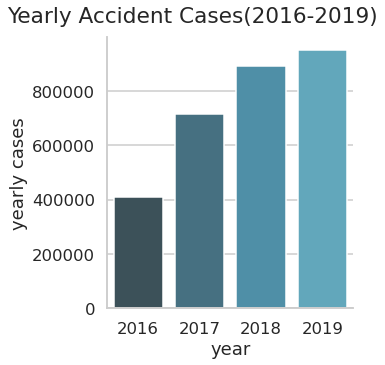

In [13]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('GnBu_d')
a = sns.catplot(x='Year',data=df_clean[df_clean['Year'] < 2020],kind='count')
a.fig.suptitle('Yearly Accident Cases(2016-2019)',y=1.03)
a.set(ylabel='yearly cases',xlabel='year')
plt.show()

**Month**

There were more accident cases druing August and December compared to other months,excluding the data from 2020. It may be due to more bad weather conditions in the winter.


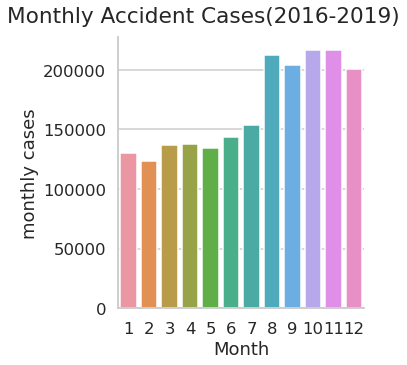

In [14]:
sns.set_context('talk')
m = sns.catplot(x='Month',data=df1[df1['Year'] < 2019],kind='count')
m.fig.suptitle('Monthly Accident Cases(2016-2019)',y=1.03)
m.set(ylabel='monthly cases')
plt.show()


**Week**

It looks like that more accidents happened on working day from Mon to Fri than on weekend.

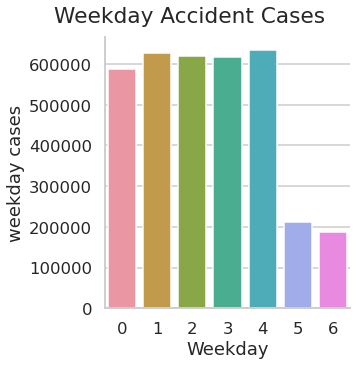

In [15]:
sns.set_context('talk')
w = sns.catplot(x='Weekday',data=df1,kind='count')
w.fig.suptitle('Weekday Accident Cases',y=1.03)
w.set(ylabel='weekday cases')
plt.show()

**Hour**

It shows that the most accidents occur at around 7-8 am in the morning and 4 to 5 pm when most people travel between home and work. The increases of the traffic density could lead to more accidents.

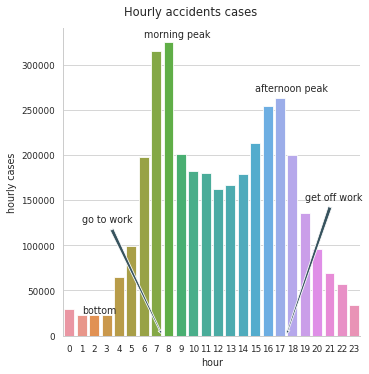

In [16]:
sns.set_context('paper')
h = sns.catplot(x='Hour',data=df1,kind='count')
h.fig.suptitle('Hourly accidents cases',y=1.03)
h.set(ylabel='hourly cases',xlabel='hour')
plt.annotate('morning peak',xy=(6,330000))
plt.annotate('afternoon peak',xy=(15,270000))
plt.annotate('bottom',xy=(1,25000))
plt.annotate('go to work',xy=(7.5,0),xytext=(1,125000),arrowprops={'arrowstyle':'fancy'})
plt.annotate('get off work',xy=(17.5,0),xytext=(19,150000),arrowprops={'arrowstyle':'fancy'})
plt.show()

**2. Data Processing and Cleaning**

**Plotting correlation matrix**

We can use this to remove highly correlated features like keeping only one of wind chill and temperature as they both mean almost the same thing.

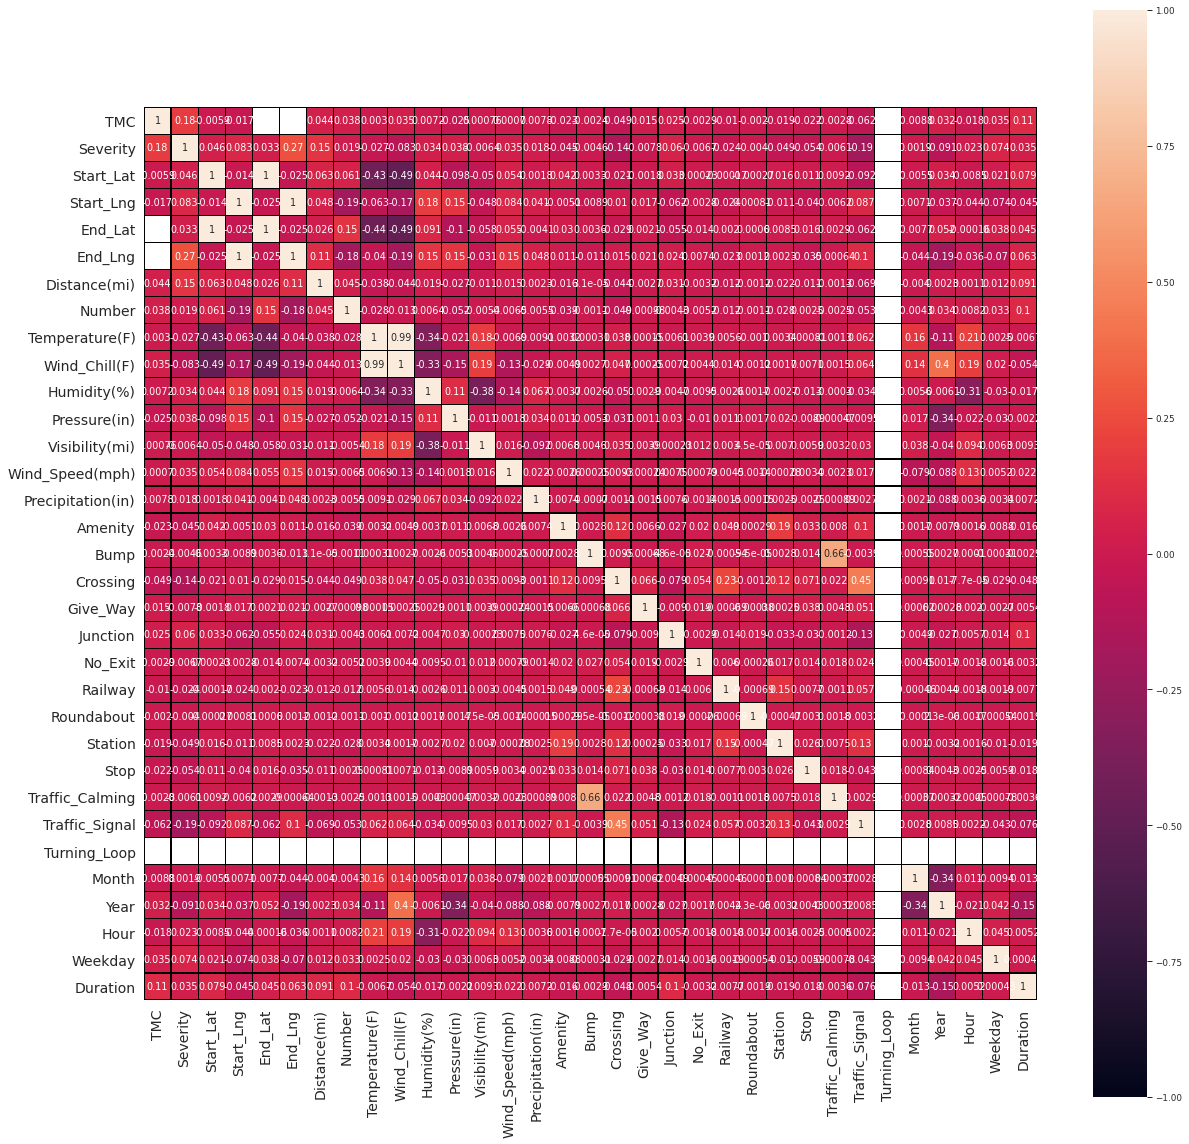

In [17]:
fig=plt.gcf()
fig.set_size_inches(20,20)
fig=sns.heatmap(df_clean.corr(),annot=True,linewidths=0.2,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

**2.1 Drop meaningless features**

Features 'Source' and 'ID' couldn't provide any useful information about accidents themselves. In addition, 'Start_time' 'End_Time' (we have year, month, weekday, hour and duration), 'End_Lat', and 'End_Lng'(we save start location) can be collected only after the accident has already happened and hence cannot be predictors for serious accident prediction. For 'TMC' and 'Description', the POI features have already been extracted from it by dataset creators. Let's get rid of these features first.

In [18]:
df_clean = df_clean.drop(['ID','TMC','Source','Description', 'End_Time', 'End_Lat', 'End_Lng'], axis=1)

Drop 'Country' and 'Turning_Loop' which have only one class.

In [20]:
cat_names = ['Side', 'Country', 'Timezone', 'Amenity', 'Bump', 'Crossing', 
             'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 
             'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 
             'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
print("Unique count of categorical features:")
for i in cat_names:
  print(i,df[i].unique().size)

Unique count of categorical features:
Side 3
Country 1
Timezone 5
Amenity 2
Bump 2
Crossing 2
Give_Way 2
Junction 2
No_Exit 2
Railway 2
Roundabout 2
Station 2
Stop 2
Traffic_Calming 2
Traffic_Signal 2
Turning_Loop 1
Sunrise_Sunset 3
Civil_Twilight 3
Nautical_Twilight 3
Astronomical_Twilight 3


In [21]:
df_clean = df_clean.drop(['Country','Turning_Loop'], axis=1)
df_clean.columns

Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)',
       'Number', 'Street', 'Side', 'City', 'County', 'State', 'Zipcode',
       'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight', 'Month', 'Year', 'Hour',
       'Weekday', 'Duration'],
      dtype='object')

**2.2 Handling missing data**

2.2.1 Get the ratio and the columns with missing values

In [22]:
missing_df = df_clean.isnull().sum(axis=0).reset_index()
missing_df.columns = ['columns_name','missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] /df_clean.shape[0]
missing_df.loc[missing_df['missing_ratio']>0]

,columns_name,missing_count,missing_ratio
5,Number,2249747,0.644490
8,City,110,0.000032
11,Zipcode,1004,0.000288
12,Timezone,3805,0.001090
13,Airport_Code,6679,0.001913
14,Weather_Timestamp,43023,0.012325
15,Temperature(F),65270,0.018698
16,Wind_Chill(F),1860561,0.532999
17,Humidity(%),69195,0.019822
18,Pressure(in),55492,0.015897


2.2.2 Missing more than 50%

'Number' and 'Wind_Chill(F)' will be dropped because they are not highly related to severity according to previous research, whereas 'Precipitation(in)' could be a useful predictor and hence can be handled by separating feature.Drop 'Number', 'Wind_Chill(F)'. 
Add a new feature for missing values in 'Precipitation(in)' and replace missing values with median.

In [23]:
missin = missing_df.loc[missing_df['missing_count']>500000]
removelist = missin['columns_name'].tolist()
removelist

['Number', 'Wind_Chill(F)', 'Precipitation(in)']

In [24]:
df_clean = df_clean.drop(['Number','Wind_Chill(F)'], axis=1)

In [25]:
df_clean['Precipitation_NA'] = 0
df_clean.loc[df_clean['Precipitation(in)'].isnull(),'Precipitation_NA'] = 1
df_clean['Precipitation(in)'] = df_clean['Precipitation(in)'].fillna(df_clean['Precipitation(in)'].median())
df_clean.loc[:5,['Precipitation(in)','Precipitation_NA']]

,Precipitation(in),Precipitation_NA
0,0.02,0
1,0.00,0
2,0.00,1
3,0.00,1
4,0.00,1
5,0.03,0


2.2.3 Missing less than 1% 

Drop NaN by features:
There still are some missing values but much less. Just dropna by these features for the sake of simplicity.


In [26]:
df_clean = df_clean.dropna(subset=['City','Zipcode','Timezone','Airport_Code',
                       'Sunrise_Sunset','Civil_Twilight',
                       'Nautical_Twilight','Astronomical_Twilight'])

2.2.4 Others

The other absent values will be imputed by employing the most common value
for categorical features and the median for continuous ones.

Weather Data with missing values

> - Continuous weather features with missing values:
Temperature(F),
Humidity(%),
Pressure(in),
Visibility(mi),
Wind_Speed(mph),

Before imputation, weather features will be grouped by location and time first, to which weather is naturally related. 'Airport_Code' is selected as location feature because the sources of weather data are airport-based weather stations. Then the data will be grouped by 'Start_Month' rather than 'Start_Hour' because using the former is computationally cheaper and remains less missing values. Finally, missing values will be replaced by median value of each group.

In [27]:
# group data by 'Airport_Code' and 'Start_Month' then fill NAs with median value
Weather_data=['Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)']
print("The number of remaining missing values: ")
for i in Weather_data:
  df_clean[i] = df_clean.groupby(['Airport_Code','Month'])[i].apply(lambda x: x.fillna(x.median()))
  print( i + " : " + df_clean[i].isnull().sum().astype(str))


The number of remaining missing values: 
Temperature(F) : 7111
Humidity(%) : 7120
Pressure(in) : 7084
Visibility(mi) : 17234
Wind_Speed(mph) : 17273


In [28]:
df_clean = df_clean.dropna(subset=Weather_data)

- Categorical Weather Features:

For categorical weather features, majority rather than median will be used to replace missing values.

In [29]:
# group data by 'Airport_Code' and 'Start_Month' then fill NAs with majority value
from collections import Counter
weather_cat = ['Wind_Direction','Weather_Condition']
print("Count of missing values that will be dropped: ")
for i in weather_cat:
  df_clean[i] = df_clean.groupby(['Airport_Code','Month'])[i].apply(lambda x: x.fillna(Counter(x).most_common()[0][0]) if all(x.isnull())==False else x)
  print(i + " : " + df_clean[i].isnull().sum().astype(str))

Count of missing values that will be dropped: 
Wind_Direction : 20422
Weather_Condition : 24251


In [30]:
# drop na
df_clean = df_clean.dropna(subset=weather_cat)

**2.3 Transformation and Simplification of Categorical features**

For categorical variables, some attributes have more than 20
levels, leading to numerous attributes after dummy coding. Therefore, it would be more practical to simplify
them into a few levels. Moreover, relative old features with raw data, outliers and negative features can be removed.

2.3.1 Time features

Time features has been normalized during EDA overview chapter. 




2.3.2 Weather features

- Wind Direction

In [31]:
print("Wind Direction: ", df_clean['Wind_Direction'].unique())

Wind Direction:  ['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' 'CALM' 'S' 'VAR'
 'N']


In [32]:
#Simplify wind direction
df = df_clean
df.loc[df['Wind_Direction']=='Calm','Wind_Direction'] = 'CALM'
df.loc[(df['Wind_Direction']=='West')|(df['Wind_Direction']=='WSW')|(df['Wind_Direction']=='WNW'),'Wind_Direction'] = 'W'
df.loc[(df['Wind_Direction']=='South')|(df['Wind_Direction']=='SSW')|(df['Wind_Direction']=='SSE'),'Wind_Direction'] = 'S'
df.loc[(df['Wind_Direction']=='North')|(df['Wind_Direction']=='NNW')|(df['Wind_Direction']=='NNE'),'Wind_Direction'] = 'N'
df.loc[(df['Wind_Direction']=='East')|(df['Wind_Direction']=='ESE')|(df['Wind_Direction']=='ENE'),'Wind_Direction'] = 'E'
df.loc[df['Wind_Direction']=='Variable','Wind_Direction'] = 'VAR'
print("Wind Direction after simplification: ", df['Wind_Direction'].unique())

Wind Direction after simplification:  ['CALM' 'SW' 'S' 'W' 'NW' 'N' 'VAR' 'SE' 'E' 'NE']


- Weather Condition

Weather-related vehicle accidents kill more people annually than large-scale weather disasters(source: weather.com). According to Road Weather Management Program, wet-pavement during rainfall, winter-condition and fog are the main reasons for weather-related accidents. To extract these three weather conditions, we first look at what we have in 'Weather_Condition' Feature.

In [33]:
# show distinctive weather conditions 
weather ='!'.join(df['Weather_Condition'].dropna().unique().tolist())
weather = np.unique(np.array(re.split(
    "!|\s/\s|\sand\s|\swith\s|Partly\s|Mostly\s|Blowing\s|Freezing\s", weather))).tolist()
print("Weather Conditions: ", weather)

Weather Conditions:  ['', 'Clear', 'Cloudy', 'Drifting Snow', 'Drizzle', 'Dust', 'Dust Whirls', 'Dust Whirls Nearby', 'Dust Whirlwinds', 'Fair', 'Fog', 'Funnel Cloud', 'Hail', 'Haze', 'Heavy ', 'Heavy Drizzle', 'Heavy Ice Pellets', 'Heavy Rain', 'Heavy Rain Shower', 'Heavy Rain Showers', 'Heavy Sleet', 'Heavy Smoke', 'Heavy Snow', 'Heavy T-Storm', 'Heavy Thunderstorms', 'Ice Pellets', 'Light ', 'Light Drizzle', 'Light Fog', 'Light Hail', 'Light Haze', 'Light Ice Pellets', 'Light Rain', 'Light Rain Shower', 'Light Rain Showers', 'Light Sleet', 'Light Snow', 'Light Snow Grains', 'Light Snow Shower', 'Light Snow Showers', 'Light Thunderstorm', 'Light Thunderstorms', 'Low Drifting Snow', 'Mist', 'N/A Precipitation', 'Overcast', 'Partial Fog', 'Patches of Fog', 'Rain', 'Rain Shower', 'Rain Showers', 'Sand', 'Scattered Clouds', 'Shallow Fog', 'Showers in the Vicinity', 'Sleet', 'Small Hail', 'Smoke', 'Snow', 'Snow Grains', 'Snow Showers', 'Squalls', 'T-Storm', 'Thunder', 'Thunder in the Vici

In [34]:
#Create features for some common weather conditions.
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear', case=False, na = False), 1, 0)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), 1, 0)
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Rain|storm', case=False, na = False), 1, 0)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), 1, 0)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), 1, 0)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls', case=False, na = False), 1, 0)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog', case=False, na = False), 1, 0)


Drop old features with raw data

In [35]:
df = df.drop(['Start_Time','Weather_Timestamp','Weather_Condition'], axis=1)

- Continuous Weather Features

Normalize features with extreamly skewed distribution.

In [36]:
df['Pressure_bc']= boxcox(df['Pressure(in)'].apply(lambda x: x+1),lmbda=6)
df['Visibility_bc']= boxcox(df['Visibility(mi)'].apply(lambda x: x+1),lmbda = 0.1)
df['Wind_Speed_bc']= boxcox(df['Wind_Speed(mph)'].apply(lambda x: x+1),lmbda=-0.2)
df = df.drop(['Pressure(in)','Visibility(mi)','Wind_Speed(mph)'], axis=1)

In [37]:
#Change Name Back
df['Pressure(in)'] = df['Pressure_bc']
df['Visibility(mi)'] = df['Visibility_bc']
df['Wind_Speed(mph)'] = df['Wind_Speed_bc']
df = df.drop(['Pressure_bc','Visibility_bc','Wind_Speed_bc'], axis=1)


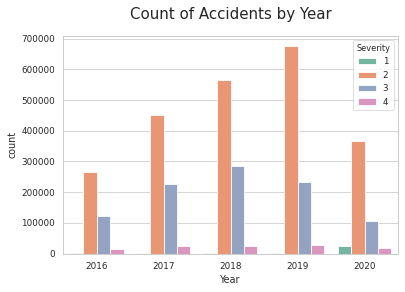

In [38]:
df.Year = df.Year.astype(str)
sns.countplot(x='Year', hue='Severity', data=df ,palette="Set2")
plt.title('Count of Accidents by Year', size=15, y=1.05)
plt.show()

**3. Feature Engineering**

3.1 Encoding Features

3.1.1 Address features

- Frequency Encoding

Some location features that have too many unique values can be labeled by their frequency. Frequency encoding and log-transform:

'Street'

'City'

'County'
 
'Zipcode'

'Airport_Code'

In [39]:
fre_list = ['Street', 'City', 'County', 'Zipcode', 'Airport_Code']
for i in fre_list:
  newname = i + '_Freq'
  df[newname] = df.groupby([i])[i].transform('count')
  df[newname] = df[newname]/df.shape[0]*df[i].unique().size
  df[newname] = df[newname].apply(lambda x: np.log(x+1))

In [40]:
df = df.drop(fre_list, axis  = 1)

3.1.2 POI features

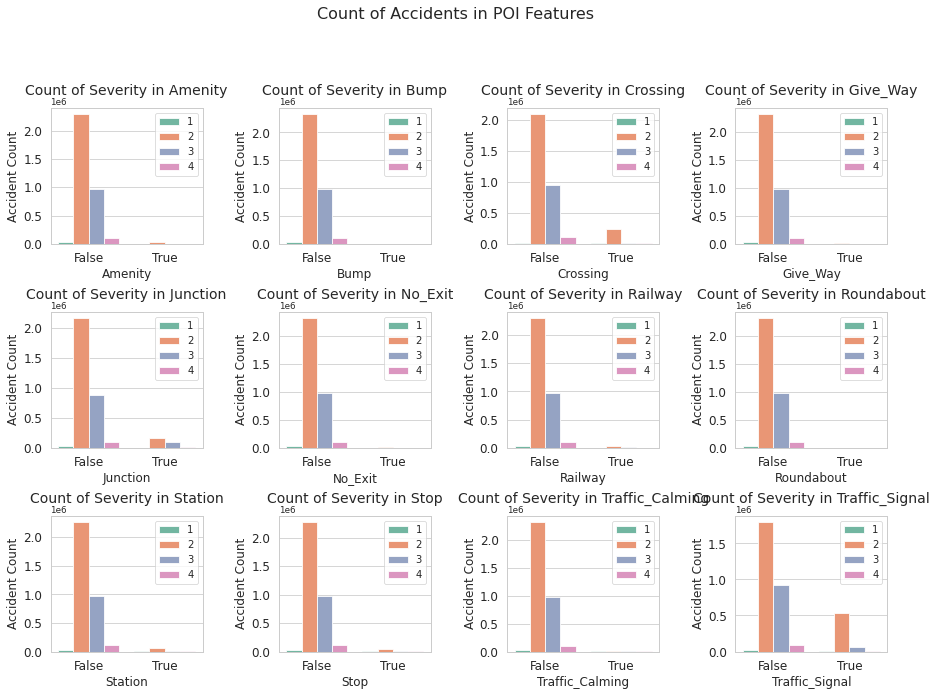

In [41]:
POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 10))

plt.subplots_adjust(hspace=0.5,wspace = 0.5)
for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='Severity', data=df, palette="Set2")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['1','2','3','4'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in {}'.format(feature), size=14, y=1.05)
fig.suptitle('Count of Accidents in POI Features',y=1.02, fontsize=16)
plt.show()

Accidents near traffic signal and crossing are much less likely to be serious accidents while little more likely to be serious if they are near the junction. Maybe it is because people usually slow down in front of crossing and traffic signal but junction and severity are highly related to speed. Other POI features are so unbalanced that it is hard to tell their relation with severity from plots.

In [42]:
df= df.drop(['Bump','Give_Way','No_Exit','Roundabout','Traffic_Calming'], axis=1)

3.2 Correlation

In [43]:
#drop features with duplicated meanings and high correlation
df = df.drop(['Civil_Twilight', 'Nautical_Twilight', 
              'Astronomical_Twilight'], axis=1)


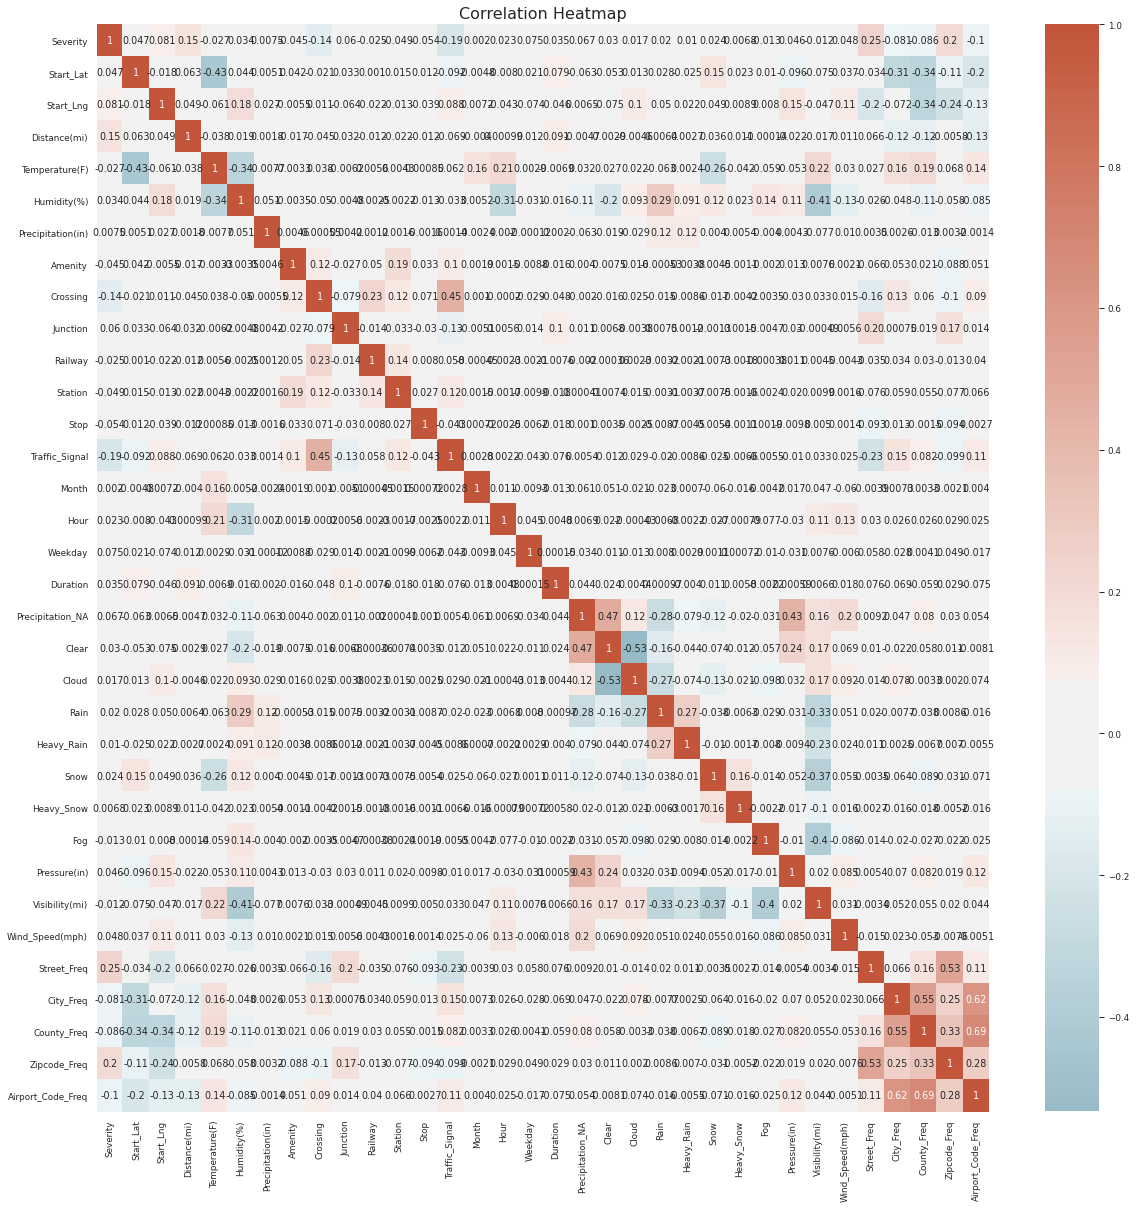

In [44]:
df['Severity'] = df['Severity'].astype(int)
plt.figure(figsize=(20,20))
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
sns.heatmap(df.corr(), annot=True,cmap=cmap, center=0).set_title("Correlation Heatmap", fontsize=16)
plt.show()

In [45]:
#drop high corrolated features
df = df.drop(['County_Freq','Zipcode_Freq',
              'Airport_Code_Freq','Year'], axis=1)

In [46]:
df = df.replace([True, False], [1,0])

In [ ]:
df.to_csv('/kaggle/working/df_revised.csv')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3435205 entries, 0 to 3513616
Data columns (total 36 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Severity           int64  
 1   Start_Lat          float64
 2   Start_Lng          float64
 3   Distance(mi)       float64
 4   Side               object 
 5   State              object 
 6   Timezone           object 
 7   Temperature(F)     float64
 8   Humidity(%)        float64
 9   Wind_Direction     object 
 10  Precipitation(in)  float64
 11  Amenity            int64  
 12  Crossing           int64  
 13  Junction           int64  
 14  Railway            int64  
 15  Station            int64  
 16  Stop               int64  
 17  Traffic_Signal     int64  
 18  Sunrise_Sunset     object 
 19  Month              int64  
 20  Hour               int64  
 21  Weekday            int64  
 22  Duration           float64
 23  Precipitation_NA   int64  
 24  Clear              int64  
 25  Cloud             

In [48]:
#Check if it contains Null value again.
missingdf = df.isnull().sum(axis=0).reset_index()
missingdf.columns = ['columns_name','missing_count']
missingdf['missing_ratio'] = missingdf['missing_count'] /df.shape[0]
missingdf.loc[missingdf['missing_ratio']>0]

,columns_name,missing_count,missing_ratio


3.3 Data Resampling

In [49]:
df["Severity"].value_counts()

2    2325575
3     975626
4     107087
1      26917
Name: Severity, dtype: int64

In [66]:
#df_bl = df.sample(frac=0.05) 
#not as good as resampling. Directly resampling!

In [132]:
df_bl = pd.concat([df[df['Severity']==2].sample(25000, random_state=42),
                   df[df['Severity']==3].sample(2500, random_state=42),
                   df[df['Severity']==4].sample(50000, random_state=42),
                   df[df['Severity']==1].sample(1000, replace = True, random_state=42)], axis=0)

df_bl["Severity"].value_counts()

4    50000
2    25000
3     2500
1     1000
Name: Severity, dtype: int64

3.4 One-hot Encoding

In [133]:
# Generate dummies for categorical data
cat = ['Side','State','Timezone','Wind_Direction', 'Weekday', 'Month', 'Hour','Sunrise_Sunset']
df_bl[cat] = df_bl[cat].astype('category')
df_bl = pd.get_dummies(df_bl, columns=cat, drop_first=True)
df_bl.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Precipitation(in),Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Duration,Precipitation_NA,Clear,Cloud,Rain,Heavy_Rain,Snow,Heavy_Snow,Fog,Pressure(in),Visibility(mi),Wind_Speed(mph),Street_Freq,City_Freq,Side_R,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Timezone_US/Eastern,Timezone_US/Mountain,Timezone_US/Pacific,Wind_Direction_E,Wind_Direction_N,Wind_Direction_NE,Wind_Direction_NW,Wind_Direction_S,Wind_Direction_SE,Wind_Direction_SW,Wind_Direction_VAR,Wind_Direction_W,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,Hour_11,Hour_12,Hour_13,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23,Sunrise_Sunset_Night
1631137,2,30.353336,-97.705627,0.000,91.0,48.0,0.0,1,0,0,0,1,0,1,29.800000,1,0,1,0,0,0,0,0,1.470605e+08,2.709816,1.457316,4.311313,5.382733,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1863980,2,28.599169,-81.268333,0.000,80.1,48.0,0.0,0,1,0,0,0,0,0,29.750000,1,0,1,0,0,0,0,0,1.558174e+08,2.709816,1.926813,3.617303,4.604017,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1765040,2,32.770512,-96.799545,0.000,79.0,84.0,0.0,0,0,0,0,0,0,0,44.533333,1,0,1,0,0,0,0,0,1.490661e+08,2.589254,1.592246,1.233345,5.398175,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3359763,2,34.235029,-118.934136,0.006,50.0,59.0,0.0,0,0,0,0,0,0,0,30.000000,1,1,0,0,0,0,0,0,1.528514e+08,2.709816,1.592246,0.883384,0.118497,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3034558,2,46.352100,-94.118440,0.000,31.0,69.0,0.0,0,0,0,0,0,0,0,193.500000,0,0,0,0,0,0,0,0,1.050208e+08,2.709816,1.904780,2.175307,0.494218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [134]:
df_bl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78500 entries, 1631137 to 2910240
Columns: 130 entries, Severity to Sunrise_Sunset_Night
dtypes: float64(12), int64(16), uint8(102)
memory usage: 25.0 MB


4. Model Building

In [117]:
# Import DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import LogisticRegression
from sklearn.linear_model import LogisticRegression

#Import Others
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [135]:
# List of classification algorithms
algo_lst=['Logistic Regression','Decision Trees','Random Forest', 
          'Support Vector Machine', 'Neural network', 'XGBoost' ]

# Initialize an empty list for the accuracy score for each algorithm
accuracy_lst=[]

# Initialize an empty list for the f1 score for each algorithm
f1_lst=[]

In [136]:
X = df_bl.drop('Severity',axis=1)
y = df_bl['Severity']


# split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(\
              X, y, test_size=0.20, random_state=42, stratify=y)

In [137]:
#----------------Logistic regression
from sklearn.linear_model import LogisticRegression
import time
tic2 = time.time()
lr = LogisticRegression(max_iter=1000,random_state=42)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Get the f1 score
f1_lr=f1_score(y_test, y_pred, average='weighted')

# Append to the accuracy list
accuracy_lst.append(acc)
f1_lst.append(f1_lr)

# Display results
print("[Logistic regression algorithm] accuracy_score: {:.3f}.".format(acc))
print("[Logistic regression algorithm] f1_score: {:.3f}.".format(f1_lr))
toc2 = time.time()
print('Elapsed time for Losigtic regression is %f seconds \n' % float(toc2 - tic2))

[Logistic regression algorithm] accuracy_score: 0.637.
[Logistic regression algorithm] f1_score: 0.496.
Elapsed time for Losigtic regression is 1.194474 seconds 



In [138]:
#------------------Decision tree algorithm
# 1. Instantiate dt_entropy, set 'entropy' as the information criterion
dt_entropy = DecisionTreeClassifier(criterion='entropy')

# 1. Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# 1. Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# 1. Evaluate accuracy_entropy
accuracy_entropy = accuracy_score(y_test, y_pred)

# 1. Get the f1 score
f1_dt_entropy=f1_score(y_test, y_pred, average='weighted')

# Append to the accuracy list
#accuracy_lst.append(acc)
#f1_lst.append(f1_lr)

# 1. Print accuracy_entropy
print('[Decision Tree -- entropy] accuracy_score: {:.3f}.'.format(accuracy_entropy))
print("[Decision Tree -- entropy] f1_score: {:.3f}.".format(f1_dt_entropy))

tic3 = time.time()

# 2. Instantiate dt_gini, set 'gini' as the information criterion
dt_gini = DecisionTreeClassifier(criterion='gini')

# 2. Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# 2. Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# 2. Evaluate accuracy_entropy
accuracy_gini = accuracy_score(y_test, y_pred)

# 2. Get the f1 score
f1_dt_gini=f1_score(y_test, y_pred, average='weighted')

# 2. Append to the accuracy list
acc=accuracy_gini
accuracy_lst.append(acc)
f1_lst.append(f1_dt_gini)

# 2. Print accuracy_gini
print('[Decision Tree -- gini] accuracy_score: {:.3f}.'.format(accuracy_gini))
print("[Decision Tree -- gini] f1_score: {:.3f}.".format(f1_dt_gini))

toc3 = time.time()
print('Elapsed time for Decision tree is %f seconds \n' % float(toc3 - tic3))


[Decision Tree -- entropy] accuracy_score: 0.846.
[Decision Tree -- entropy] f1_score: 0.846.
[Decision Tree -- gini] accuracy_score: 0.837.
[Decision Tree -- gini] f1_score: 0.837.
Elapsed time for Decision tree is 2.993967 seconds 



In [139]:
# --------------Random Forest algorithm
tic4 = time.time()
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Get the f1 score
f1_clf=f1_score(y_test, y_pred, average='weighted')

# Append to the accuracy list
accuracy_lst.append(acc)
f1_lst.append(f1_clf)

# Model Accuracy, how often is the classifier correct?
print("[Randon forest algorithm] accuracy_score: {:.3f}.".format(acc))
print("[Randon forest algorithm] f1_score: {:.3f}.".format(f1_clf))
toc4 = time.time()
print('Elapsed time for Randon forest is %f seconds \n' % float(toc4 - tic4))

[Randon forest algorithm] accuracy_score: 0.889.
[Randon forest algorithm] f1_score: 0.874.
Elapsed time for Randon forest is 35.621099 seconds 



In [123]:
import pickle
filename = 'RF.sav'
#pickle.dump(clf, open(filename, 'wb'))
pickle.dump(clf, open('RF.pickle', 'wb'))

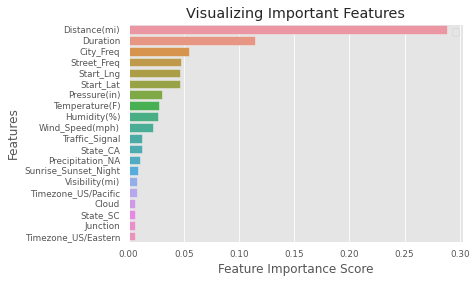

In [140]:
#Algorithm Random Forest
#Visualize important features
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_columns', 350)
plt.style.use('ggplot')

feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

# Creating a bar plot, displaying only the top k features
k=20
sns.barplot(x=feature_imp[:20], y=feature_imp.index[:k])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [141]:
# List top k important features
k=20
feature_imp.sort_values(ascending=False)[:k]

Distance(mi)            0.288645
Duration                0.114791
City_Freq               0.054972
Street_Freq             0.047690
Start_Lng               0.046928
Start_Lat               0.046757
Pressure(in)            0.030578
Temperature(F)          0.027690
Humidity(%)             0.026859
Wind_Speed(mph)         0.022216
Traffic_Signal          0.012344
State_CA                0.012266
Precipitation_NA        0.010579
Sunrise_Sunset_Night    0.008658
Visibility(mi)          0.008103
Timezone_US/Pacific     0.007628
Cloud                   0.005677
State_SC                0.005644
Junction                0.005517
Timezone_US/Eastern     0.005467
dtype: float64

In [142]:
#Algorithm Random Forest
#Select the top important features, set the threshold
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.03
sfm = SelectFromModel(clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_train)

feat_labels=X.columns

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])

Start_Lat
Start_Lng
Distance(mi)
Duration
Pressure(in)
Street_Freq
City_Freq


In [143]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

# Create a new random forest classifier for the most important features
clf_important = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
clf_important.fit(X_important_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

In [145]:
# Apply The Full Featured Classifier To The Test Data
y_pred = clf.predict(X_test)

# View The Accuracy Of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_pred)))

# Apply The Full Featured Classifier To The Test Data
y_important_pred = clf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] accuracy_score: {:.3f}.'.format(accuracy_score(y_test, y_important_pred)))

#View The F1 Score of Our Full Feature Model
print('[Randon forest algorithm -- Full feature] f1_score: {:.3f}.'.format(f1_score(y_test, y_pred, average='weighted')))

# View The F1 Score Of Our Limited Feature Model
print('[Randon forest algorithm -- Limited feature] f1_score: {:.3f}.'.format(f1_score(y_test, y_important_pred, average='weighted')))

[Randon forest algorithm -- Full feature] accuracy_score: 0.889.
[Randon forest algorithm -- Limited feature] accuracy_score: 0.889.
[Randon forest algorithm -- Full feature] f1_score: 0.874.
[Randon forest algorithm -- Limited feature] f1_score: 0.880.


In [130]:
import pickle
filename = 'RF_limit.sav'
#pickle.dump(clf, open(filename, 'wb'))
pickle.dump(clf_important, open('RF_limit.pickle', 'wb'))

In [146]:
#--------------- Support vector machine algorithm
from sklearn import svm
tic5 = time.time()

svm = svm.SVC(gamma='auto')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Get f1-score
f1_svm=f1_score(y_test, y_pred, average='weighted')

# Append to the accuracy list
accuracy_lst.append(acc)
f1_lst.append(f1_svm)

print("[Support vector machine algorithm] accuracy_score: {:.3f}.".format(acc))
print("[Support vector machine algorithm] f1_score: {:.3f}.".format(f1_svm))
toc5 = time.time()
print('Elapsed time for Support vector machine is %f seconds \n' % float(toc5 - tic5))

[Support vector machine algorithm] accuracy_score: 0.708.
[Support vector machine algorithm] f1_score: 0.664.
Elapsed time for Support vector machine is 6884.623917 seconds 



In [ ]:
#--------------- Neural network algorithm
from sklearn import neural_network
import time

tic6 = time.time()
nn = neural_network.MLPClassifier(hidden_layer_sizes=(5, 2))
nn.fit(X_train,y_train)
y_pred=nn.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# f1_score
f1_nn=f1_score(y_test, y_pred, average='weighted')

# Append to the accuracy list
accuracy_lst.append(acc)
f1_lst.append(f1_nn)

print("[Neural network algorithm] accuracy_score: {:.3f}.".format(acc))
print("[Neural network algorithm] f1_score: {:.3f}.".format(f1_nn))
toc6 = time.time()
print('Elapsed time for Neural network is %f seconds \n' % float(toc6 - tic6))

In [131]:
#--------------- XGBoost algorithm
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
tic7 = time.time()
xgb = XGBClassifier(objective= 'multi:softmax',num_class=4,n_fold=4,
                    colsample_bytree = 1,
                    learning_rate = 0.15,
                    max_depth = 5,
                    n_estimators = 600,
                    subsample = 0.3)
xgb.fit(X_train, y_train)

y_pred=xgb.predict(X_test)

# Get the accuracy score
acc=accuracy_score(y_test, y_pred)

# Get f1 score
f1_xgb=f1_score(y_test, y_pred, average='weighted')

# Append to the accuracy list
accuracy_lst.append(acc)
f1_lst.append(f1_xgb)


print("[XGBoost algorithm] accuracy_score: {:.3f}.".format(acc))
print("[XGBoost algorithm] f1_score: {:.3f}.".format(f1_xgb))
toc7 = time.time()
print('Elapsed time for Losigtic regression is %f seconds \n' % float(toc7 - tic7))

[16:24:43] WARNING: ../src/learner.cc:516: 
Parameters: { n_fold } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




KeyboardInterrupt: 

In [ ]:
# Make a plot of the accuracy scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, accuracy_lst)), columns=['Algorithm','Accuracy_Score']).sort_values(by=['Accuracy_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./Accuracy_scores_algorithms.csv',index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'Accuracy_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)


# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('Accuracy Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('Which algorithm is better regarding accuracy score?')

plt.show()

In [ ]:
# Make a plot of the f1 scores for different algorithms

# Generate a list of ticks for y-axis
y_ticks=np.arange(len(algo_lst))

# Combine the list of algorithms and list of accuracy scores into a dataframe, sort the value based on accuracy score
df_acc=pd.DataFrame(list(zip(algo_lst, f1_lst)), columns=['Algorithm','F1_Score']).sort_values(by=['F1_Score'],ascending = True)

# Export to a file
df_acc.to_csv('./f1_scores_algorithms.csv',index=False)

# Make a plot
ax=df_acc.plot.barh('Algorithm', 'F1_Score', align='center',legend=False,color='0.5')

# Add the data label on to the plot
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.02, i.get_y()+0.2, str(round(i.get_width(),2)), fontsize=10)


# Set the limit, lables, ticks and title
plt.xlim(0,1.1)
plt.xlabel('F1 Score')
plt.yticks(y_ticks, df_acc['Algorithm'], rotation=0)
plt.title('Which algorithm is better regarding f1 score?')

plt.show()